In [1]:
import os
import pickle
from importlib import reload

import torch
import numpy as np
import sciplots as plots
from scipy.stats import pearsonr
from netloader import transforms
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from src.main import init
from src.utils import analysis
from src.utils.utils import open_config
from src.utils.clustering import CompactClusterEncoder

reload(plots)
import sciplots as plots

reload(analysis)
from src.utils.analysis import multi_batch_train_summary, batch_train_summary

In [2]:
_, config = open_config('main', '../config.yaml')

net_epochs = config['training']['epochs']
states_dir = config['output']['network-states-directory']
plots_dir = config['output']['plots-directory']

bahamas_colours = ['#0049E0', '#0090E0', '#00D7E0', '#2CDEE6', '#00E09E', '#00E051'][:-2]
bahamas_agn_colours = ['#F54EDF', '#5D4EF5']
bahamas_dmo = ['#00FA8F', '#01FB3D', '#89FA00']
flamingo_colours = ['#FABD00', '#FA7700', '#FA2100']
flamingo_test = ['#FA07A0']

In [3]:
data = multi_batch_train_summary(-1, '../data/', (1, 6))
labels = ['FLAMINGO Low Test', 'FLAMINGO Low', 'FLAMINGO', 'FLAMINGO High', 'BAHAMAS-0 Low', 'BAHAMAS-0', 'BAHAMAS-0 High', 'BAHAMAS-0.1', 'BAHAMAS-0.3', 'BAHAMAS-1']
x_data = np.array([5e-4, 1e-3, 2.28e-3, 5e-3, 1e-2])

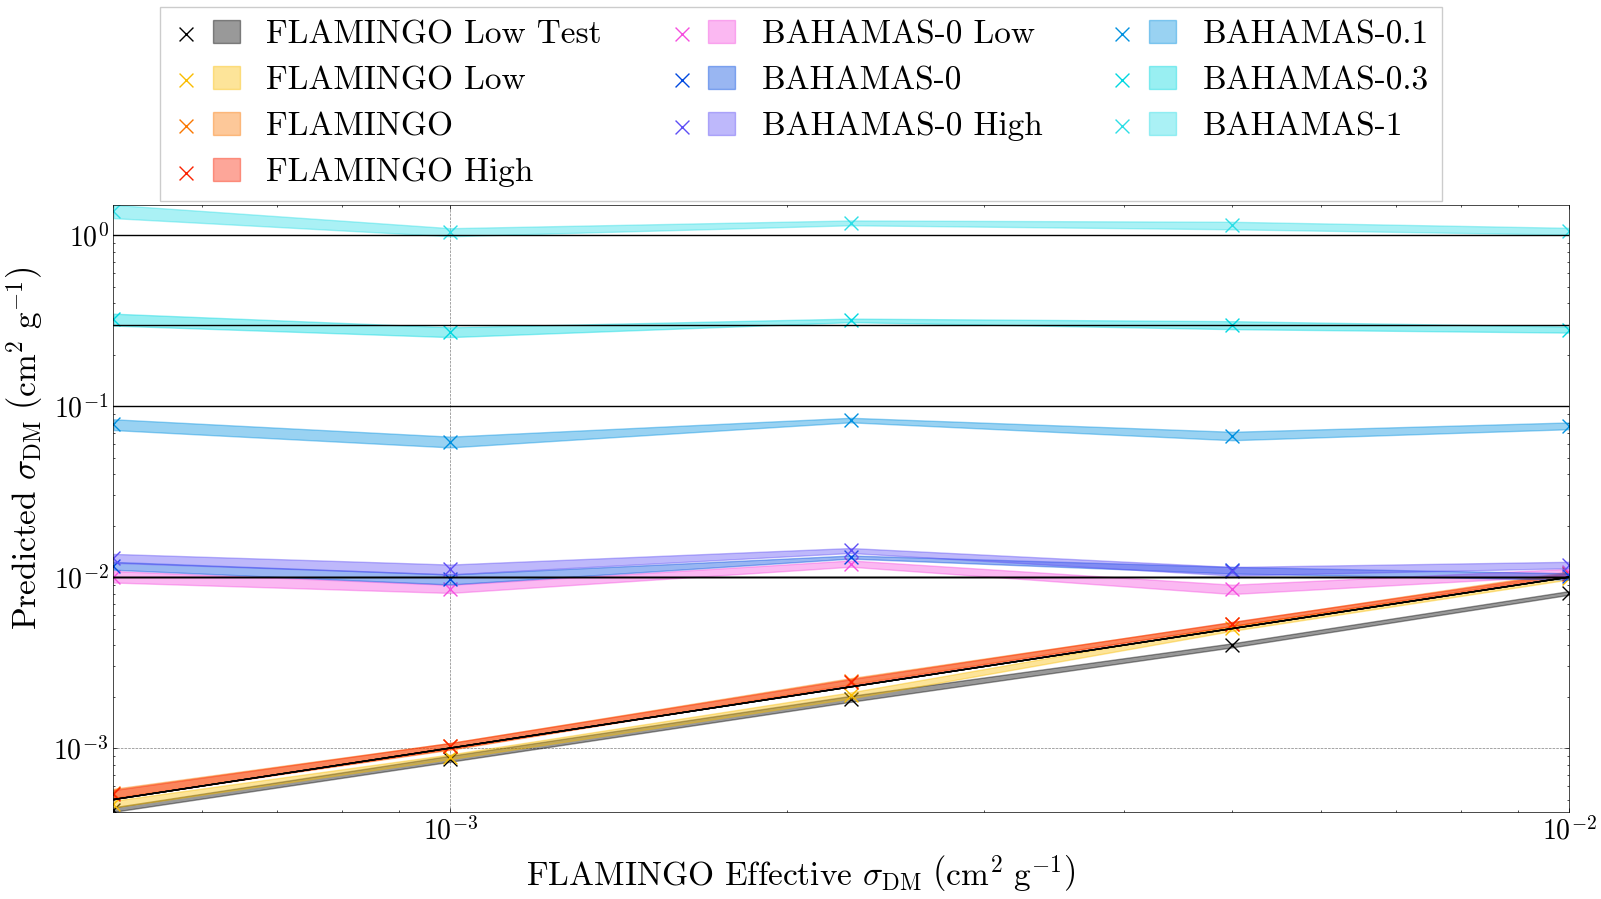

In [84]:
plot = plots.PlotComparison(
    x_data,
    data['weighted_means'].swapaxes(0, 1),
    log_x=True,
    log_y=True,
    axis_pad=False,
    error_region=True,
    alpha=1,
    x_label=r'FLAMINGO Effective $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    y_label=r'Predicted $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    labels=labels,
    target=[*[x_data] * 4, *[np.ones_like(x_data) * 0.01] * 3, np.ones_like(x_data) * 0.1, np.ones_like(x_data) * 0.3, np.ones_like(x_data)],
    y_error=data['stes'].swapaxes(0, 1),
    colours=['k'] + flamingo_colours + bahamas_agn_colours[:1] + bahamas_colours[:1] + bahamas_agn_colours[-1:] + bahamas_colours[1:]
)

In [4]:
param_transform = transforms.MultiTransform(
    transforms.Log(),
)
param_transform.append(transforms.Normalise(data=param_transform(np.unique(data['targets'], axis=1).squeeze()[:, 1:]), mean=False, dim=1))
log_targets = param_transform(np.unique(data['targets'], axis=1).squeeze())

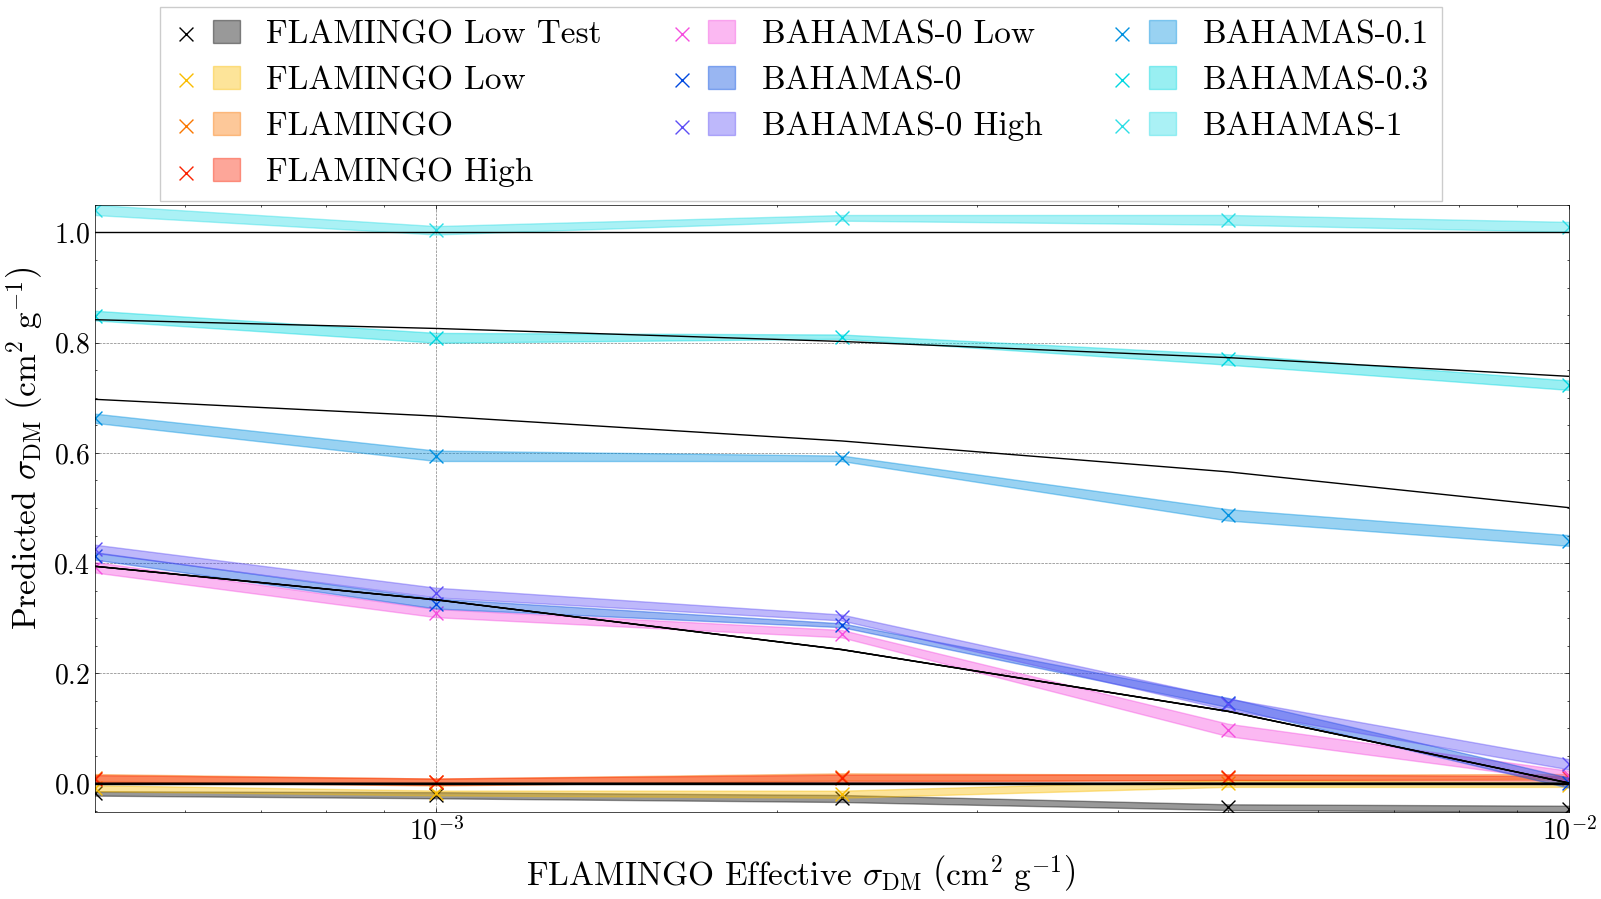

In [77]:
plot = plots.PlotComparison(
    x_data,
    data['log_weighted_means'].swapaxes(0, 1),
    log_x=True,
    # log_y=True,
    axis_pad=False,
    error_region=True,
    alpha=1,
    x_label=r'FLAMINGO Effective $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    y_label=r'Predicted $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    labels=labels,
    target=log_targets.swapaxes(0, 1),
    # target=[*[x_data] * 4, *[np.ones_like(x_data) * 0.01] * 3, np.ones_like(x_data) * 0.1, np.ones_like(x_data) * 0.3, np.ones_like(x_data)],
    y_error=data['log_stes'].swapaxes(0, 1),
    colours=['k'] + flamingo_colours + bahamas_agn_colours[:1] + bahamas_colours[:1] + bahamas_agn_colours[-1:] + bahamas_colours[1:]
)

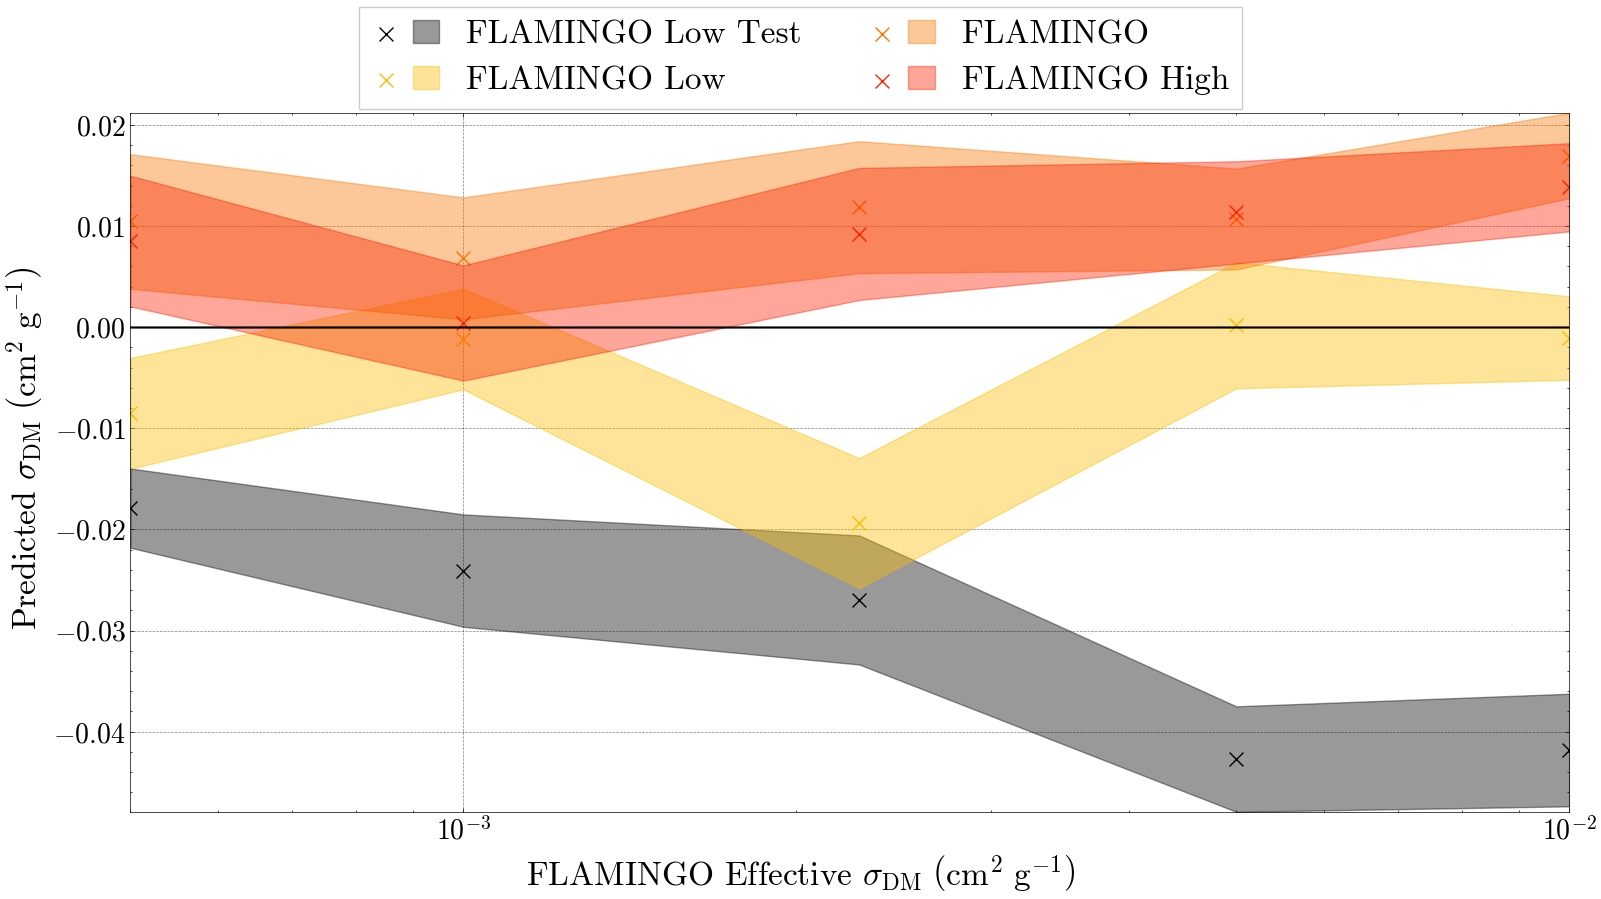

In [5]:
# slice_ = slice(4, -1)
plot = plots.PlotComparison(
    x_data,
    (data['log_weighted_means'] - log_targets).swapaxes(0, 1)[:4],
    log_x=True,
    # log_y=True,
    axis_pad=False,
    error_region=True,
    alpha=1,
    x_label=r'FLAMINGO Effective $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    y_label=r'Predicted $\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    labels=labels[:4],
    target=np.zeros_like(x_data),
    # target=[*[x_data] * 4, *[np.ones_like(x_data) * 0.01] * 3, np.ones_like(x_data) * 0.1, np.ones_like(x_data) * 0.3, np.ones_like(x_data)],
    y_error=data['log_stes'].swapaxes(0, 1)[:4],
    colours=['k', *flamingo_colours, bahamas_agn_colours[0], bahamas_colours[0], bahamas_agn_colours[-1], *bahamas_colours[1:]][:4]
)

In [ ]:
plot.savefig('../plots/', name='cdm_tests')

In [5]:
targets = np.stack([*[x_data] * 4, *[np.ones_like(x_data) * 0.01] * 3, np.ones_like(x_data) * 0.1, np.ones_like(x_data) * 0.3, np.ones_like(x_data)], axis=1)
(data['means'][-1] - targets[-1] - data['means'][0] + targets[0]) / np.sqrt((data['stes'][-1] ** 2 + data['stes'][0] ** 2) / 2)
# (data['means'][idxs][-1] - targets[-1]) / data['stes'][idxs][-1] - (data['means'][idxs][0] - targets[0]) / data['stes'][idxs][0]
# data['means'][idxs][-1] - targets[-1] - data['means'][idxs][0] + targets[0]

array([-11.26989574,  -0.29485379,   5.10119759,   4.26436656,
        -0.41392766,  -1.84070482,  -0.84803693,  -0.29296753,
        -2.25248607,  -5.23181567])

In [88]:
const = lambda x, c: c
# lin_fixed = lambda x, m: m * x
lin = lambda x, m, c: m * x + c

def red_chi_sq(pred, target, error, dof):
    return np.sum(((pred - target) / error) ** 2) / dof

def f_test(target, pred_1, pred_2, dof_1, dof_2):
    ssr_1 = np.sum((pred_1 - target) ** 2)
    ssr_2 = np.sum((pred_2 - target) ** 2)
    return (ssr_1 ** 2 - ssr_2 ** 2) * dof_2 / ((dof_1 - dof_2) * ssr_2 ** 2)

for label, target, means, stes in zip(labels, targets.swapaxes(0, 1), data['weighted_means'].swapaxes(0, 1).copy(), data['stes'].swapaxes(0, 1)):
    means -= target

    popt_const, pcov_const = curve_fit(const, x_data, means, sigma=stes)
    popt_lin, pcov_lin = curve_fit(lin, x_data, means, sigma=stes)

    chi_const = red_chi_sq(means, const(x_data, *popt_const), stes, len(means) - 1)
    chi_lin = red_chi_sq(means, lin(x_data, *popt_lin), stes, len(means) - 2)
    chi_data = red_chi_sq(means, np.zeros_like(target), stes, len(means))
    print(f"{label} ({target}, {means}):\n"
          f"Const C: {popt_const[0]:.2e}+-{np.sqrt(pcov_const[0, 0]):.2e}\n"
          f"Linear M: {popt_lin[0]:.2e}+-{np.sqrt(pcov_lin[0, 0]):.2e}, C: {popt_lin[1]:.2e}+-{np.sqrt(pcov_lin[1, 1]):.2e}\n"
          f"Const Model Reduced Chi Squared: {chi_const:.2f}\n"
          f"Linear Model Reduced Chi Squared: {chi_lin:.2f}\n"
          f"Data Reduced Chi Squared: {chi_data:.2f}\n"
          f"Const AIC: {chi_const * (len(means) - 1) + 2:.2f}, BIC: {chi_const * (len(means) - 1) + np.log(len(means)):.2f}\n"
          f"Linear AIC: {chi_lin * (len(means) - 2) + 4:.2f}, BIC: {chi_lin * (len(means) - 2) + 2 * np.log(len(means)):.2f}\n")
          # f"F-Test Const: {f_test(target, means, const(x_data, *popt_const), len(means), len(means) - 1)}\n"
          # f"F-Test Linear: {f_test(target, const(x_data, *popt_const), lin(x_data, *popt_lin), len(means) - 1, len(means) - 2)}\n")

FLAMINGO Low Test ([0.0005  0.001   0.00228 0.005   0.01   ], [-6.30791386e-05 -1.33147307e-04 -3.37850264e-04 -1.01053599e-03
 -1.91839303e-03]):
Const C: -9.68e-05+-7.89e-05
Linear M: -1.95e-01+-1.16e-02, C: 3.87e-05+-1.24e-05
Const Model Reduced Chi Squared: 42.13
Linear Model Reduced Chi Squared: 0.59
Data Reduced Chi Squared: 46.41
Const AIC: 170.53, BIC: 170.14
Linear AIC: 5.78, BIC: 5.00

FLAMINGO Low ([0.0005  0.001   0.00228 0.005   0.01   ], [-2.94730405e-05 -1.10049169e-04 -2.44772035e-04  1.78271263e-05
 -1.30869892e-04]):
Const C: -6.64e-05+-2.66e-05
Linear M: -2.11e-02+-2.78e-02, C: -4.81e-05+-3.70e-05
Const Model Reduced Chi Squared: 2.61
Linear Model Reduced Chi Squared: 2.92
Data Reduced Chi Squared: 5.34
Const AIC: 12.44, BIC: 12.05
Linear AIC: 12.75, BIC: 11.97

FLAMINGO ([0.0005  0.001   0.00228 0.005   0.01   ], [4.41478445e-05 2.39498573e-05 1.85167604e-04 3.01570621e-04
 5.86919911e-04]):
Const C: 6.38e-05+-4.35e-05
Linear M: 5.91e-02+-1.05e-02, C: 1.70e-06+-1.85

In [89]:
for label, target, means, stes in zip(labels, log_targets.swapaxes(0, 1), data['log_weighted_means'].swapaxes(0, 1).copy(), data['log_stes'].swapaxes(0, 1)):
    means -= target

    popt_const, pcov_const = curve_fit(const, x_data, means, sigma=stes)
    popt_lin, pcov_lin = curve_fit(lin, x_data, means, sigma=stes)

    chi_const = red_chi_sq(means, const(x_data, *popt_const), stes, len(means) - 1)
    chi_lin = red_chi_sq(means, lin(x_data, *popt_lin), stes, len(means) - 2)
    chi_data = red_chi_sq(means, np.zeros_like(target), stes, len(means))
    print(f"{label}:\n"
          f"Const C: {popt_const[0]:.2e}+-{np.sqrt(pcov_const[0, 0]):.2e}\n"
          f"Linear M: {popt_lin[0]:.2e}+-{np.sqrt(pcov_lin[0, 0]):.2e}, C: {popt_lin[1]:.2e}+-{np.sqrt(pcov_lin[1, 1]):.2e}\n"
          f"Const Model Reduced Chi Squared: {chi_const:.2f}\n"
          f"Linear Model Reduced Chi Squared: {chi_lin:.2f}\n"
          f"Data Reduced Chi Squared: {chi_data:.2f}\n"
          f"Const AIC: {chi_const * (len(means) - 1) + 2:.2f}, BIC: {chi_const * (len(means) - 1) + np.log(len(means)):.2f}\n"
          f"Linear AIC: {chi_lin * (len(means) - 2) + 4:.2f}, BIC: {chi_lin * (len(means) - 2) + 2 * np.log(len(means)):.2f}\n")
          # f"F-Test Const: {f_test(target, means, const(x_data, *popt_const), len(means), len(means) - 1)}\n"
          # f"F-Test Linear: {f_test(target, const(x_data, *popt_const), lin(x_data, *popt_lin), len(means) - 1, len(means) - 2)}\n")

FLAMINGO Low Test:
Const C: -2.91e-02+-5.83e-03
Linear M: -3.14e+00+-7.27e-01, C: -1.87e-02+-3.47e-03
Const Model Reduced Chi Squared: 6.52
Linear Model Reduced Chi Squared: 1.21
Data Reduced Chi Squared: 37.61
Const AIC: 28.06, BIC: 27.67
Linear AIC: 7.62, BIC: 6.84

FLAMINGO Low:
Const C: -8.95e-03+-3.76e-03
Linear M: 1.40e+00+-7.17e-01, C: -1.52e-02+-4.29e-03
Const Model Reduced Chi Squared: 2.80
Linear Model Reduced Chi Squared: 1.65
Data Reduced Chi Squared: 5.42
Const AIC: 13.22, BIC: 12.82
Linear AIC: 8.94, BIC: 8.16

FLAMINGO:
Const C: 1.03e-02+-1.72e-03
Linear M: 5.75e-01+-4.02e-01, C: 7.39e-03+-2.55e-03
Const Model Reduced Chi Squared: 0.50
Linear Model Reduced Chi Squared: 0.39
Data Reduced Chi Squared: 3.97
Const AIC: 3.99, BIC: 3.60
Linear AIC: 5.18, BIC: 4.40

FLAMINGO High:
Const C: 8.39e-03+-1.30e-03
Linear M: 2.59e-01+-3.57e-01, C: 7.08e-03+-2.27e-03
Const Model Reduced Chi Squared: 0.30
Linear Model Reduced Chi Squared: 0.34
Data Reduced Chi Squared: 2.75
Const AIC: 3

In [7]:
targets = np.stack([*[x_data] * 4, *[np.ones_like(x_data) * 0.01] * 3, np.ones_like(x_data) * 0.1, np.ones_like(x_data) * 0.3, np.ones_like(x_data)], axis=1)
np.mean(((data['means'] - targets) / data['stes']) ** 2, axis=0)

array([38.8996506 ,  1.21680103,  7.40285921,  5.5516612 ,  6.13781848,
       33.309976  , 31.16556019, 32.94156307,  2.38126894, 11.92815856])

In [4]:
data = batch_train_summary(3, '../data/', idx=0)
data.keys()

dict_keys(['means', 'weighted_means', 'stds', 'stes', 'errors', 'description', 'sims', 'unknown_sims'])

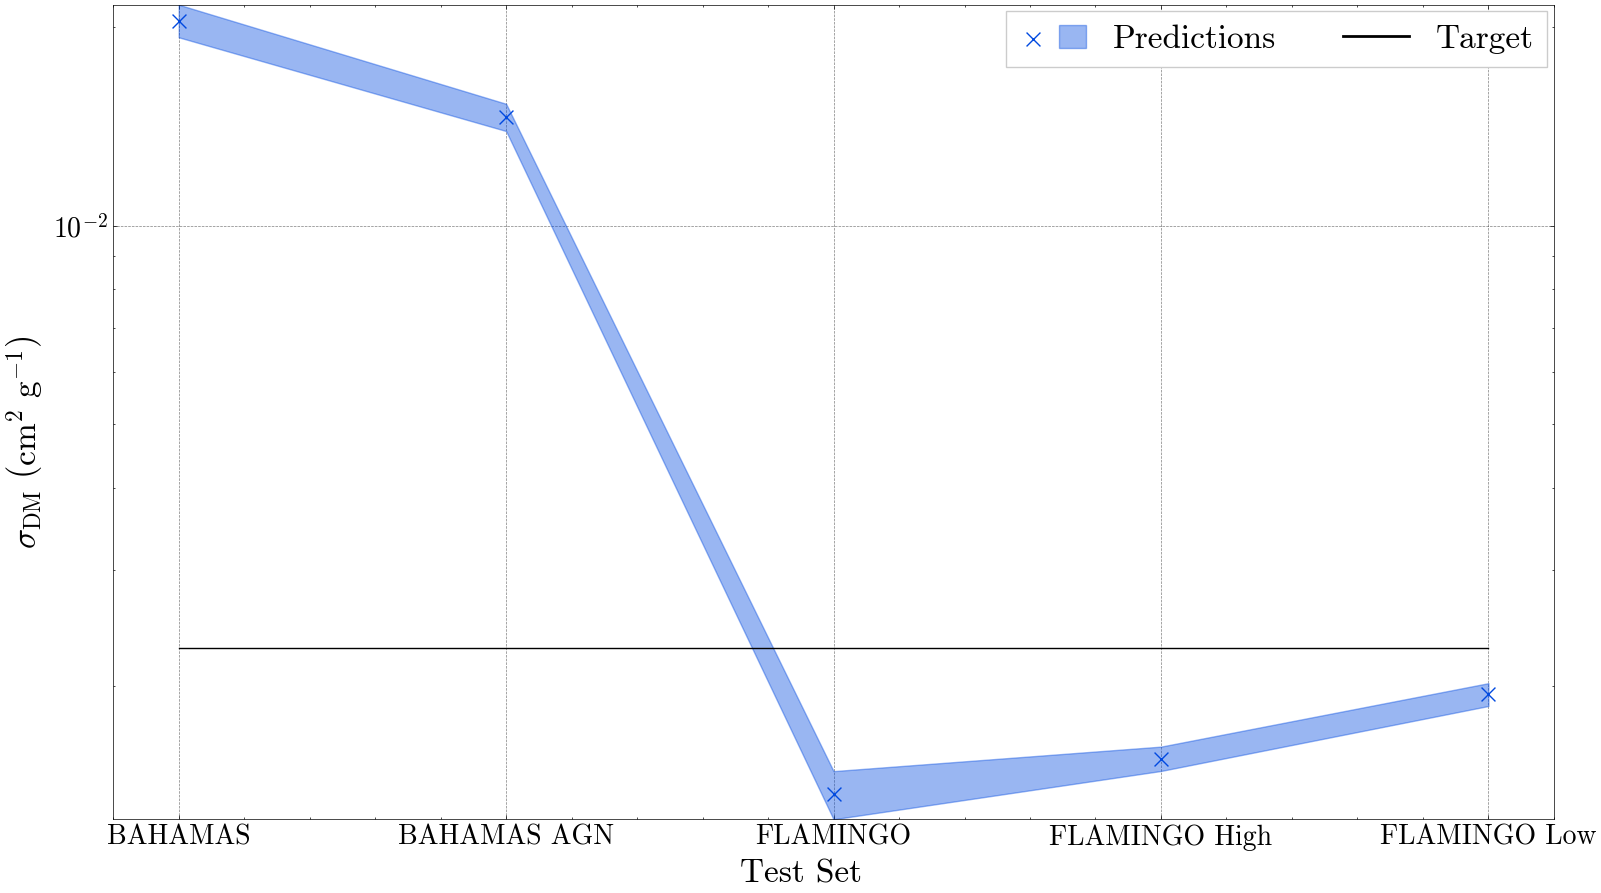

In [5]:
plot = plots.PlotPlots(
    np.array(['BAHAMAS', 'BAHAMAS AGN', 'FLAMINGO', 'FLAMINGO High', 'FLAMINGO Low']),
    [data['weighted_means'], np.ones_like(data['means']) * 2.28e-3],
    log_y=True,
    axis_pad=False,
    error_region=True,
    x_label='Test Set',
    y_label=r'$\sigma_{\rm DM}\ \left(\rm cm^2\ g^{-1}\right)$',
    y_error=[data['stes'], None],
    labels=['Predictions', 'Target'],
    markers=['x', None],
    colours=[bahamas_colours[0], 'k'],
    axis=True,
    alpha=1,
    loc='best',
)

In [6]:
plot.savefig('../plots/', name='flamingo_low_cdm_2.28e-3')

In [2]:
_, config = open_config('main', '../config.yaml')
loaders, net, dataset = init(['flamingo', 'flamingo_low', 'flamingo_hi', 'bahamas_cdm', 'bahamas_cdm_low', 'bahamas_cdm_hi', 'bahamas_0.1', 'bahamas_0.3', 'bahamas_1'], config, unknown=['flamingo_low_test'])


Training data size: 32480	Validation data size: 8120


In [52]:
predictions = []
for net in data['nets'][1]:
    predictions.append(net.predict(loaders[1]))

Prediction time: 2.807e+00 s
Prediction time: 2.786e+00 s
Prediction time: 2.798e+00 s
Prediction time: 2.818e+00 s
Prediction time: 2.890e+00 s
Prediction time: 2.867e+00 s
Prediction time: 2.867e+00 s
Prediction time: 2.923e+00 s
Prediction time: 2.864e+00 s
Prediction time: 2.804e+00 s


In [53]:
for net, prediction in zip(data['nets'][-1], predictions):
    prediction['latent'][:, 0] = net.transforms['targets'](prediction['latent'][:, 0], back=True)

In [54]:
distributions = []

for prediction in predictions:
    idxs = np.unique(prediction['targets']).flatten()[7] == prediction['targets'].flatten()
    distributions.append(prediction['latent'][idxs, 0])

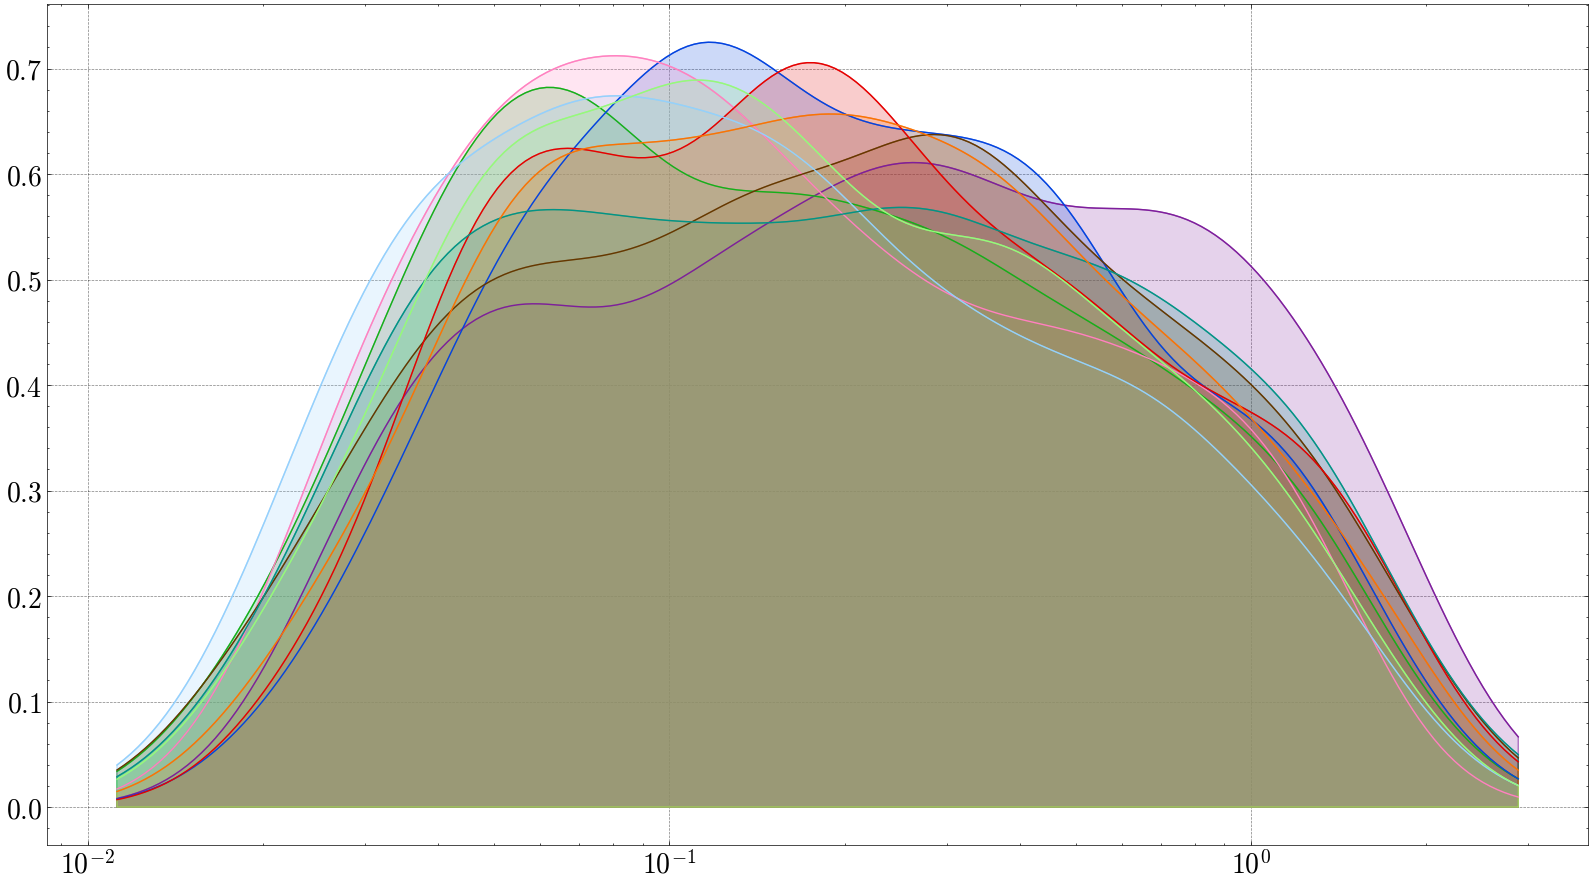

In [78]:
plot = plots.PlotDistribution(
    distributions,
    log=True,
    density=True,
    bins=200,
    alpha_2d=0.2,
)

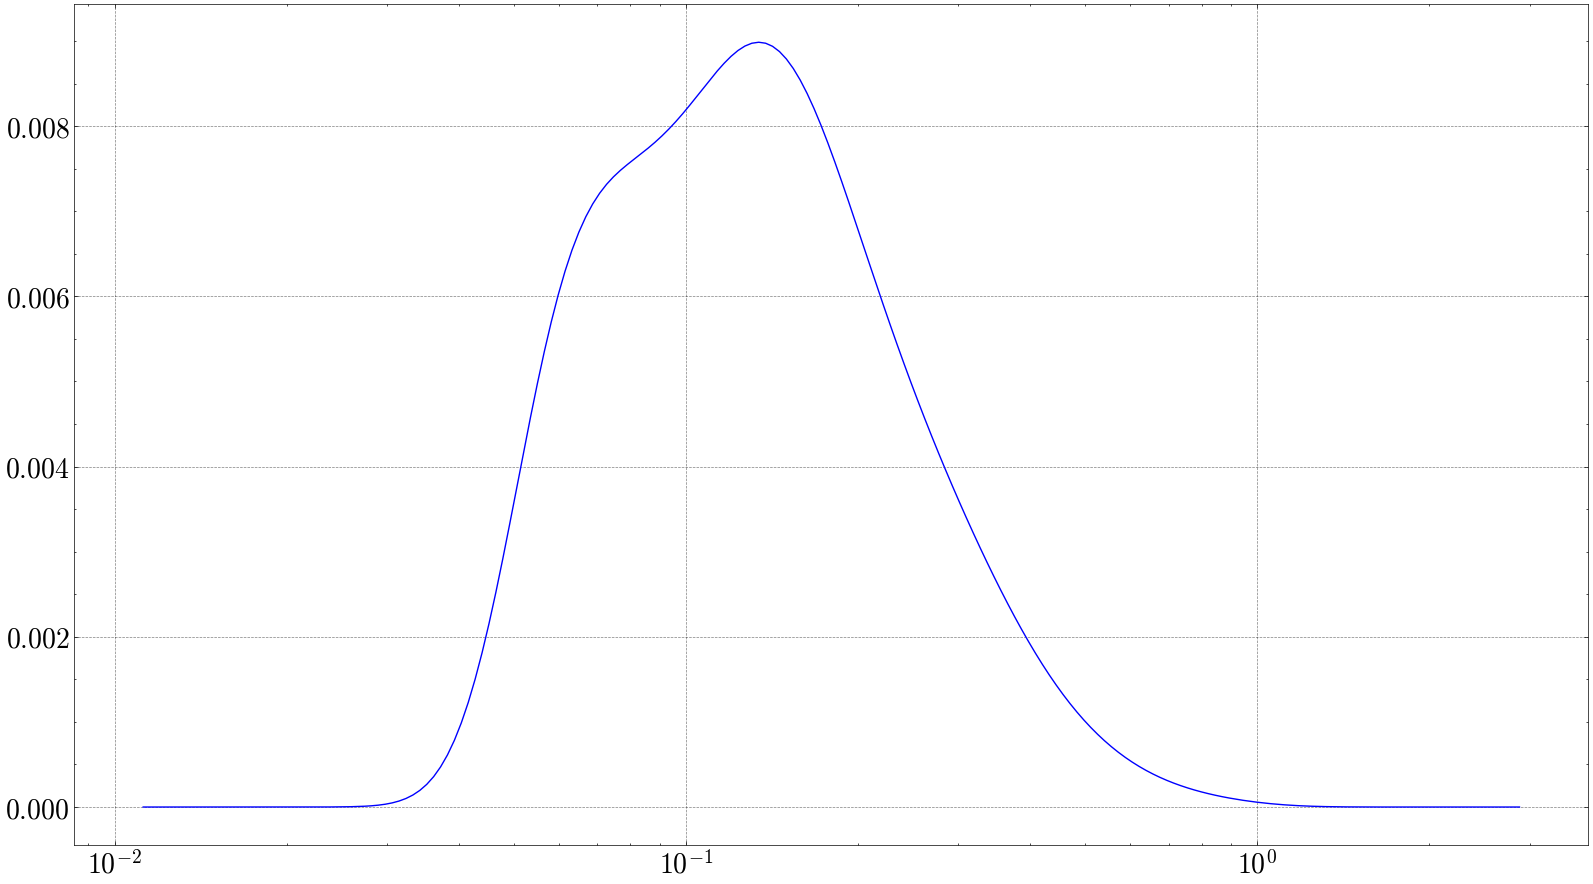

In [79]:
from scipy.ndimage import gaussian_filter as gauss
a=np.array([plot_poly.get_ydata() for plot_poly in plot.plots[::2]])
b = plot.plots[::2][0].get_xdata()
plots.PlotPlots(
    b,
    # gauss(np.prod(a, axis=0),5),
    np.prod(a, axis=0),
    log_x=True,
    markers='',
    colours='blue',
)

In [81]:
np.mean(np.prod(a, axis=0)), np.std(np.prod(a, axis=0)), np.quantile(np.prod(a, axis=0), 0.16), np.quantile(np.prod(a, axis=0), 0.84), np.quantile(np.prod(a, axis=0), 0.05), np.quantile(np.prod(a, axis=0), 0.95)

(np.float64(0.002598085460998116),
 np.float64(0.003250849136184452),
 np.float64(2.011546012866198e-09),
 np.float64(0.007416606714313488),
 np.float64(3.2938931136717773e-14),
 np.float64(0.008680281166737722))

0.1233928829778434 0.11754184629425043 0.0565741465990449


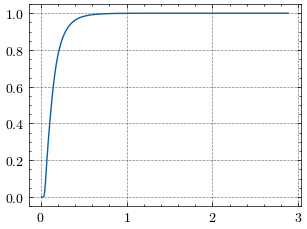

In [94]:
x = b
y = np.prod(a, axis=0)

np.sum(x * y) / np.sum(y)
c = np.cumsum(y) / np.sum(y)
med = x[np.argmin(np.abs(c - 0.5))]
upper = x[np.argmin(np.abs(c - 0.84))]
lower = x[np.argmin(np.abs(c - 0.16))]
print(med, upper - med, med - lower)
plt.plot(x,c)